# ATTN: This script uses Google translate to detect job description language. Google translate will limit requests and take a very long time. Only run this script if redoing language detection.

# Read from scrapped data

In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


#### Read paths

In [ ]:
glob_paths = list(set(glob.glob(f'{scraped_data}Coding Material/*Folder/*/Job ID -*- Codebook (Automating Equity).xlsx')))


In [ ]:
# 244 xlsx files
len(glob_paths)


#### Use paths to open files, fix keywords, and drop unneeded columns

In [ ]:
# Fix list catches all incorrect/faculty keyword search terms

fix_list = []

# Appended data catches all the fixed and cleaned dfs
appended_data = []

for glob_path in glob_paths:

    try:
        df_temp = pd.read_excel(glob_path).reset_index(drop=True)
    except ValueError:
        fix_list.append(glob_path)

    if len(df_temp) > 0 and isinstance(df_temp, pd.DataFrame):
        df_temp.reset_index(drop=True, inplace=True)
        df_temp.drop(columns=cols, axis='columns', inplace=True, errors='ignore')
        df_temp.drop(
        df_temp.columns[
                df_temp.columns.str.contains(
                    'unnamed|index|level', regex=True, case=False, flags=re.I
                )
            ],
            axis='columns',
            inplace=True,
            errors='ignore',
        )

        appended_data.append(df_temp.reset_index(drop=True))

# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data).reset_index(drop=True)

# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
# If we couldn't fix some keywords, we add them to list fix_list and write to file
if len(fix_list) != 0:
    print('Some keywords to fix!')
    with open(f'{data_dir}fix_list.txt', 'w') as f:
        json.dump(fix_list, f)


In [ ]:
# List of dfs, len = 244
len(appended_data)


In [ ]:
# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data).reset_index(drop=True)


In [ ]:
# len = 12400
len(df_manual)


In [ ]:
# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Drop duplicated and missing data

### START HERE IF SOURCING FROM df_manual_RAW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW

In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw.pkl').reset_index(drop=True)


In [ ]:
# len = 12400
len(df_manual)


In [ ]:
df_manual.info()


In [ ]:
df_manual.columns

In [ ]:
# Clean columns
df_manual.columns = df_manual.columns.to_series().apply(lambda x: str(x).strip())


In [ ]:
# Remove columns 'Task_Mentioned', 'Task_Warmth', 'Task_Competence'
df_manual.drop(
    columns=['Task_Mentioned', 'Task_Warmth', 'Task_Competence'],
    axis='columns',
    inplace=True,
    errors='ignore'
)

In [ ]:
df_manual['Warmth'] = df_manual['Warmth'].astype(np.float64)
df_manual['Competence'] = df_manual['Competence'].astype(np.float64)


In [ ]:
df_manual.info()


In [ ]:
# Rename Sentence to 'Job Description spacy_sentencized'
df_manual.rename(
    columns = {
        'Sentence': 'Job Description spacy_sentencized'
    },
    inplace=True,
    errors='ignore'
)

In [ ]:
df_manual.columns


In [ ]:
# Drop NA
df_manual.dropna(axis='index', how='all', inplace=True)
df_manual.dropna(axis='columns', how='all', inplace=True)
df_manual.dropna(
    subset = ['Job Description spacy_sentencized', 'Warmth', 'Competence'],
    inplace=True
)


In [ ]:
# len = 12394
len(df_manual)


In [ ]:
# len = 133
df_manual.groupby(['Job ID'])['Job ID'].unique()


In [ ]:
# Drop duplicates on subset of 'Job ID' and 'Sentence'
df_manual.drop_duplicates(subset=['Job ID', 'Job Description spacy_sentencized'], keep='first', ignore_index=True, inplace=True)


In [ ]:
# len = 6400
len(df_manual)


In [ ]:
# Remove any rows with missing 'Job ID'
df_manual.drop(
    df_manual[
        (df_manual['Job ID'].isin(nan_list)) | 
        (df_manual['Job ID'].isnull()) | 
        (df_manual['Job ID'].isna())
    ].index, 
    axis='index',
    inplace=True,
    errors='ignore'
)


In [ ]:
# len = 6400
len(df_manual)


In [ ]:
# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_dropped.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Add English and Dutch language requirement columns

### START HERE IF SOURCING FROM df_manual_RAW_DROPPED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl').reset_index(drop=True)


In [ ]:
# 6400
len(df_manual)


In [ ]:
df_manual.info()


In [ ]:
# Add language requirement column
# Use regex to find language requirement
dutch_requirement_pattern = r'[Ll]anguage: [Dd]utch|[Dd]utch [Pp]referred|[Dd]utch [Re]quired|[Dd]utch [Ll]anguage|[Pp]roficient in [Dd]utch|[Ss]peak [Dd]utch|[Kk]now [Dd]utch'
english_requirement_pattern = r'[Ll]anguage: [Ee]nglish|[Ee]nglish [Pp]referred|[Ee]nglish [Re]quired|[Ee]nglish [Ll]anguage|[Pp]roficient in [Ee]nglish|[Ss]peak [Ee]nglish|[Kk]now [Ee]nglish'


In [ ]:
# Language requirements
# Dutch
if 'Dutch Requirement' in df_manual.columns:
    df_manual.drop(columns=['Dutch Requirement'], inplace=True)
df_manual['Dutch Requirement'] = np.where(
    df_manual['Job Description spacy_sentencized'].str.contains(dutch_requirement_pattern),
    'Yes',
    'No',
)

# English
if 'English Requirement' in df_manual.columns:
    df_manual.drop(columns=['English Requirement'], inplace=True)
df_manual['English Requirement'] = np.where(
    df_manual['Job Description spacy_sentencized'].str.contains(english_requirement_pattern),
    'Yes',
    'No',
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_english_requirement.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
# Yes = 235
df_manual['Dutch Requirement'].value_counts()


In [ ]:
# Yes = 526
df_manual['English Requirement'].value_counts()

In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_language_requirement.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Add data from Sectors dataframe (see CBS directory under scrapped_data directory)


### START HERE IF SOURCING FROM df_manual_RAW_LANGUAGE_REQUIREMENT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
# Funtion to print df gender and age info
def df_gender_age_info(
    df,
    ivs_all = [
        'Gender',
        'Gender_Num',
        'Gender_Female',
        'Gender_Mixed',
        'Gender_Male',
        'Age',
        'Age_Num',
        'Age_Older',
        'Age_Mixed',
        'Age_Younger',
    ],
):
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            counts = df[f"{iv}"].value_counts()
            percentages = df[f"{iv}"].value_counts(normalize=True).mul(100).round(1).astype(float)
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            print(f'{iv} Counts:\n{counts}')
            print('-'*20)
            print(f'{iv} Percentages:\n{percentages}')

            try:
                mean = df[f"{iv}"].mean().round(2).astype(float)
                sd = df[f"{iv}"].std().round(2).astype(float)
                print('-'*20)
                print(f'{iv} Mean: {mean}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {sd}')

            except Exception:
                pass
        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
df_manual['Job ID'] = df_manual['Job ID'].apply(lambda x: str(x).lower().strip())


In [ ]:
df_jobs = pd.read_pickle(f'{df_save_dir}df_jobs_including_sector_genage_data.pkl').reset_index(drop=True)


In [ ]:
df_jobs.info()

In [ ]:
df_jobs['Job ID'] = df_jobs['Job ID'].apply(lambda x: str(x).lower().strip())


In [ ]:
df_jobs.columns


In [ ]:
df_jobs.drop(
    columns = [
        'Job Description', 'Rating', 'Employment Type',
        'Company URL', 'Job URL', 'Job Age', 'Job Age Number',
        'Collection Date', 'Data Row', 'Tracking ID', 'Job Date',
        'Type of ownership', 'Language', 'Dutch Requirement', 'English Requirement', 
    ],
    inplace=True,
    errors='ignore'
)

In [ ]:
df_jobs.columns


In [ ]:
# Add sector and categorical data from df_jobs
df_manual = df_manual.merge(df_jobs, on='Job ID', how='inner')


In [ ]:
len(df_manual)


In [ ]:
df_manual.info()


In [ ]:
df_manual.head()

#### Check if there is any missing sector data in the merged dataframe

In [ ]:
df_manual['Sector'].isna().sum()

In [ ]:
if df_manual['Sector'].isna().sum() != 0:
    print('Some search keywords did not match a sector. Fixing')
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))
    df_manual = fix_keywords(df_manual)
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))


In [ ]:
# Manual Job Ad info
df_gender_age_info(df_manual.groupby(['Job ID']).first())


In [ ]:
# Manual Job Sentence info
df_gender_age_info(df_manual)


In [ ]:
if df_manual['Sector'].isna().sum() == 0:
    if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
        df_manual.to_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl')

        df_manual.to_csv(f'{df_save_dir}df_manual_including_sector_genage_data.csv', index=False)
    else:
        print(f'ERORR: LENGTH OF DF = {len(df_manual)}')
else:
    print(f"MISSING SECTOR DATA: COUNT {df_manual['Sector'].isna().sum()}")

# ATTN: This script should be run AFTER spacy sentence splitting is completed.


# Use spacy to tokenize sentences


### START HERE IF SOURCING FROM df_manual_SENTENCIZED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def get_word_num_and_frequency(row, text_col):

    row['Job Description num_words'] = len(str(row[f'{text_col}']).split())
    row['Job Description num_unique_words'] = len(set(str(row[f'{text_col}']).split()))
    row['Job Description num_chars'] = len(str(row[f'{text_col}']))
    row['Job Description num_punctuations'] = len([c for c in str(row[f'{text_col}']) if c in string.punctuation])

    return row


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl').reset_index(drop=True)


In [ ]:
df_manual['Job Description spacy_sentencized_lower'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: job_sentence.strip().lower()
)


In [ ]:
df_manual[['Job Description spacy_sentencized', 'Job Description spacy_sentencized_lower']].head()


In [ ]:
# Spacy tokenize
with open(f'{data_dir}punctuations.txt', 'rb') as f:
    custom_punct_chars = pickle.load(f)

df_manual['Job Description spacy_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        str(token.text.strip().lower())
        for token in nlp.tokenizer(job_sentence)
        if len(token) != 0
        and not token.is_space
        and not token.is_stop
        and not token.is_punct
        and not token.is_bracket
        and not token.like_email
        and not token.text in custom_punct_chars
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual['Job Description spacy_sentencized_cleaned'] = df_manual['Job Description spacy_tokenized'].str.join(' ')


In [ ]:
# Get sentence word frequencies
df_manual = df_manual.apply(
    lambda row: get_word_num_and_frequency(
        row=row, text_col='Job Description spacy_sentencized'
    ), 
    axis='columns',
    
)


In [ ]:
df_manual.columns


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
# Tokenize with NLTK
df_manual['Job Description nltk_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        str(token.strip().lower()) 
        for token in word_tokenize(job_sentence) 
        if len(token) != 0 
        and token != '...' 
        and not token.lower() in set(stopwords.words('english')) 
        and not token.lower() in list(string.punctuation) 
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual['Job Description nltk_tokenized'].head()


In [ ]:
df_manual.info()


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use gensim to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
df_manual['Job Description gensim_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual['Job Description gensim_tokenized'].head()


In [ ]:
df_manual.info()


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use BERT to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
df_manual['Job Description bert_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: bert_tokenizer.tokenize(str(sentence))
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual['Job Description bert_tokenized'].head()


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all tokenization (spacy, nltk, gensim, and BERT) completed.


# Use spacy to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM_BERT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
# Load customer characters
with open(f'{data_dir}punctuations.txt', 'rb') as f:
    custom_punct_chars = pickle.load(f)

# POS tagging
df_manual['Job Description spacy_token_tags'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        tuple([token.text.strip().lower(), token.tag_])
        for token in nlp(job_sentence)
        
    ]
)

# Lemmatization
df_manual['Job Description spacy_lemmas'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        token.lemma_.strip().lower()
        for token in nlp(job_sentence)
        if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
    ]
)

# Stemming
df_manual['Job Description spacy_stems'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        stemmer.stem(token.text.strip().lower())
        for token in nlp(job_sentence)
        if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual.info()


In [ ]:
df_manual[
    [
        'Job Description spacy_token_tags',
        'Job Description spacy_lemmas',
        'Job Description spacy_stems'
    ]
].head()


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def get_wordnet_pos(token):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl').reset_index(drop=True)


In [ ]:
df_manual.info()


In [ ]:
# POS stagging
df_manual['Job Description nltk_token_tags'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda token: pos_tag(token)
)

# Lemmatization
df_manual['Job Description nltk_lemmas'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        lemmatizer.lemmatize(
            token, get_wordnet_pos(
                unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            )
        )
        for token in tokens
    ]
)

# Stemming
df_manual['Job Description nltk_stems'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        stemmer.stem(
            unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        )
        for token in tokens
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual.info()


In [ ]:
df_manual[['Job Description nltk_token_tags', 'Job Description nltk_lemmas', 'Job Description nltk_stems']].head()


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use BERT to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
# import os
# import sys
# import importlib
# from pathlib import Path
# import numpy as np

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# # %load_ext autoreload
# # %autoreload 2


In [ ]:
# # MAIN DIR
# main_dir = f'{str(Path(code_dir).parents[0])}/'

# # code_dir
# code_dir = f'{code_dir}/'
# sys.path.append(code_dir)

# # scraping dir
# scraped_data = f'{code_dir}scraped_data/'

# # data dir
# data_dir = f'{code_dir}data/'

# # df save sir
# df_save_dir = f'{data_dir}final dfs/'

# # lang models dir
# llm_path = f'{data_dir}Language Models'

# # sites
# site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# # columns
# cols=['Sector', 
#       'Sector Code', 
#       'Gender', 
#       'Age', 
#       'Language', 
#       'Dutch Requirement', 
#       'English Requirement', 
#       'Gender_Female', 
#       'Gender_Mixed', 
#       'Gender_Male', 
#       'Age_Older', 
#       'Age_Mixed', 
#       'Age_Younger', 
#       'Gender_Num', 
#       'Age_Num', 
#       '% Female', 
#       '% Male', 
#       '% Older', 
#       '% Younger']

# int_variable: str = 'Job ID'
# str_variable: str = 'Job Description'
# gender: str = 'Gender'
# age: str = 'Age'
# language: str = 'en'
# languages = ["en", "['nl', 'en']", ['en', 'nl']]
# str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
# nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
# pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
# import string
# import re
# import time
# import json
# import csv
# import glob
# import pickle
# import random
# import unicodedata
# import pandas as pd
# import numpy as np
# import googletrans
# from googletrans import Translator
# random.seed(42)

# # Set up Spacy
# import spacy
# from spacy.symbols import NORM, ORTH, LEMMA, POS

# nlp = spacy.load('en_core_web_sm')

# # Set up NLK
# import nltk
# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.corpus import stopwords, wordnet
# from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
# from nltk.tag import pos_tag, pos_tag_sents

# nltk_path = f'{llm_path}/nltk'
# nltk.data.path.append(nltk_path)

# nltk.download('words', download_dir = nltk_path)
# nltk.download('stopwords', download_dir = nltk_path)
# nltk.download('punkt', download_dir = nltk_path)
# nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

# stop_words = set(stopwords.words('english'))
# punctuations = list(string.punctuation)
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# # Set up Gensim
# from gensim.utils import save_as_line_sentence, simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# # Set up Bert
# from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
# bert_model_name = 'bert-base-uncased'
# bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
# bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl').reset_index(drop=True)



In [ ]:
# bert_pos_model_name = 'QCRI/bert-base-multilingual-cased-pos-english'
# bert_pos_model = AutoModelForTokenClassification.from_pretrained(bert_pos_model_name)
# bert_pos_tagger = TokenClassificationPipeline(model=bert_pos_model, tokenizer=bert_tokenizer)

# df_manual['Job Description bert_token_tags_with_scores'] = df_manual['Job Description spacy_sentencized'].apply(
#     lambda sentence: [
#         (bert_pos_tag['word'], bert_pos_tag['entity'], bert_pos_tag['score'])
#         for i in range(len(sentence.split()))
#         for bert_pos_tag in bert_pos_tagger(sentence)
#     ]
# )

# df_manual['Job Description bert_token_tags'] = df_manual['Job Description bert_token_tags_with_scores'].apply(
#     lambda tag_list: [
#         [(tag_list[i][0], tag_list[i][1])]
#         for tag_tuple in tag_list
#         for i in range(len(tag_list))
#     ]
# )


# if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
#     df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')

#     df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv', index=False)
# else:
#     print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
# df_manual['Job Description bert_token_tags'].head()

In [ ]:
# if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
#     df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')

#     df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv', index=False)
# else:
#     print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all POS tagging, lemmatization, and stemming (spacy and nltk) completed.


# Use spacy to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def spacy_make_ngrams(sentence, matcher, gram_type):

    doc = nlp(sentence)
    matches = matcher(doc)
    matches_list = []

    for idx in range(len(matches)):
        for match_id, start, end in matches:
            if nlp.vocab.strings[match_id].split('_')[0] == gram_type:
                match = doc[matches[idx][1]: matches[idx][2]].text
                matches_list.append(match.lower())
    
    return list(set(matches_list))


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl').reset_index(drop=True)


In [ ]:
df_manual['Job Description spacy_1grams_original_list'] = df_manual['Job Description spacy_tokenized']
df_manual['Job Description spacy_1grams'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [ ]:
# Spacy bi and trigrams
matcher = Matcher(nlp.vocab)

bigram_rules = [
    ['NOUN', 'VERB'],
    ['VERB', 'NOUN'],
    ['ADJ', 'NOUN'],
    ['ADJ', 'PROPN'],
    # more rules here...
]

trigram_rules = [
    ['VERB', 'ADJ', 'NOUN'],
    ['NOUN', 'VERB', 'ADV'],
    ['NOUN', 'ADP', 'NOUN'],
    # more rules here...
]

patters_dict = {
    'bigram_patterns': [[{'POS': i} for i in j] for j in bigram_rules],
    'trigram_patterns': [[{'POS': i} for i in j] for j in trigram_rules],
}

ngram_dict = {
    'bigram': 2,
    'trigram': 3,
}

for ngram_name, ngram_num in ngram_dict.items():
    
    
    matcher.add(f'{ngram_name}_patterns', patters_dict[f'{ngram_name}_patterns'])

    df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list'] = df_manual['Job Description spacy_sentencized'].apply(
        lambda sentence: 
            [
                '_'.join(ngram_.split())
                for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
            ]
    )
    
    df_manual[f'Job Description spacy_{str(ngram_num)}grams'] = df_manual['Job Description spacy_sentencized'].apply(
        lambda sentence: 
            [
                tuple(ngram_.split())
                for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
            ]
    )

    df_manual[f'Job Description spacy_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
        regex = {
            re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
            for ngrams_list in df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list']
            for ngram_ in ngrams_list
            if '_' in ngram_
        }
    )
    
    if f'{ngram_name}_patterns' in matcher:
        matcher.remove(f'{ngram_name}_patterns')
    assert f'{ngram_name}_patterns' not in matcher


In [ ]:
# Spacy Allgrams
df_manual['Job Description spacy_123grams_original_list'] = df_manual['Job Description spacy_tokenized'] + df_manual['Job Description spacy_2grams_original_list'] + df_manual['Job Description spacy_3grams_original_list']
df_manual['Job Description spacy_123grams'] = df_manual['Job Description spacy_1grams'] + df_manual['Job Description spacy_2grams'] + df_manual['Job Description spacy_3grams']
df_manual['Job Description spacy_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description spacy_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl').reset_index(drop=True)


In [ ]:
df_manual['Job Description nltk_1grams_original_list'] = df_manual['Job Description nltk_tokenized']
df_manual['Job Description nltk_1grams'] = df_manual['Job Description nltk_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [ ]:
# NLTK bi and trigrams
ngram_dict = {
    'bigram': 2,
    'trigram': 3
}

for ngram_name, ngram_num in ngram_dict.items():

    df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list'] = df_manual['Job Description nltk_tokenized'].apply(
        lambda tokens:
            list(
                '_'.join(ngram_list)
                for ngram_list in ngrams(tokens, ngram_num)
            )
    )

    df_manual[f'Job Description nltk_{str(ngram_num)}grams'] = df_manual['Job Description nltk_tokenized'].apply(
        lambda tokens: list(ngrams(tokens, ngram_num))
    )

    df_manual[f'Job Description nltk_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
        regex = {
            re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
            for ngrams_list in df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list']
            for ngram_ in ngrams_list
            if '_' in ngram_
        }
    )


In [ ]:
# NLTK Allgrams
df_manual[f'Job Description nltk_123grams_original_list'] = df_manual['Job Description nltk_tokenized'] + df_manual['Job Description nltk_2grams_original_list'] + df_manual['Job Description nltk_3grams_original_list']
df_manual[f'Job Description nltk_123grams'] = df_manual['Job Description nltk_1grams'] + df_manual['Job Description nltk_2grams'] + df_manual['Job Description nltk_3grams']
df_manual['Job Description nltk_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description nltk_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use Gensim to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl').reset_index(drop=True)


In [ ]:
df_manual['Job Description gensim_1grams_original_list'] = df_manual['Job Description gensim_tokenized']
df_manual['Job Description gensim_1grams'] = df_manual['Job Description gensim_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [ ]:
# Gensim bi and trigrams
# Gensim Bigrams
bigram = Phraser(Phrases(df_manual['Job Description gensim_tokenized'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
df_manual['Job Description gensim_2grams_original_list_all'] = bigram[df_manual['Job Description gensim_tokenized']]
df_manual['Job Description gensim_2grams_original_list'] = df_manual['Job Description gensim_2grams_original_list_all'].apply(
    lambda ngrams_list: [
        ngram_
        for ngram_ in ngrams_list
        if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
    ]
)
df_manual['Job Description gensim_2grams'] = df_manual['Job Description gensim_2grams_original_list'].apply(
    lambda ngrams: [
        tuple(ngram.split('_'))
        for ngram in ngrams
        if '_' in ngram
    ]
)
df_manual[f'Job Description gensim_2grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_2grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)

# Gensim Trigrams
trigram = Phraser(Phrases(df_manual['Job Description gensim_2grams_original_list_all'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
df_manual['Job Description gensim_3grams_original_list_all'] = trigram[df_manual['Job Description gensim_2grams_original_list_all']]
df_manual['Job Description gensim_3grams_original_list'] = df_manual['Job Description gensim_3grams_original_list_all'].apply(
    lambda ngrams_list: [
        ngram_
        for ngram_ in ngrams_list
        if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
    ]
)
df_manual['Job Description gensim_3grams'] = df_manual['Job Description gensim_3grams_original_list'].apply(
    lambda ngrams: [
        tuple(ngram.split('_'))
        for ngram in ngrams
        if '_' in ngram
    ]
)
df_manual[f'Job Description gensim_3grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_3grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [ ]:
# Gensim Allgrams
df_manual[f'Job Description gensim_123grams_original_list'] = df_manual['Job Description gensim_tokenized'] + df_manual['Job Description gensim_2grams_original_list'] + df_manual['Job Description gensim_3grams_original_list']
df_manual[f'Job Description gensim_123grams'] = df_manual['Job Description gensim_1grams'] + df_manual['Job Description gensim_2grams'] + df_manual['Job Description gensim_3grams']
df_manual['Job Description gensim_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Create word frequencies for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def get_abs_frequency(row, text_col, ngram_num, embedding_library):

    abs_word_freq = defaultdict(int)
    for word in row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']:
        abs_word_freq[word] += 1

        abs_wtd_df = (
            pd.DataFrame.from_dict(abs_word_freq, orient='index')
            .rename(columns={0: 'abs_word_freq'})
            .sort_values(by=['abs_word_freq'], ascending=False)
            )
        abs_wtd_df.insert(1, 'abs_word_perc', value=abs_wtd_df['abs_word_freq'] / abs_wtd_df['abs_word_freq'].sum())
        abs_wtd_df.insert(2, 'abs_word_perc_cum', abs_wtd_df['abs_word_perc'].cumsum())

        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_freq'] = str(abs_wtd_df['abs_word_freq'].to_dict())
        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc'] = str(abs_wtd_df['abs_word_perc'].to_dict())
        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc_cum'] = str(abs_wtd_df['abs_word_perc_cum'].to_dict())

    return row


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl').reset_index(drop=True)


In [ ]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_num in itertools.product(embedding_libraries_list, ngrams_list):
    df_manual = df_manual.apply(lambda row: get_abs_frequency(row=row, text_col='Job Description spacy_tokenized', ngram_num=ngram_num, embedding_library=embedding_library), axis='columns')


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_frequency.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Create BoW dictionary, corpus, and tfidf matrix for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_FREQUENCY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def get_corpus_and_dictionary(row, ngram_num, embedding_library):
    
    ngrams_original_list = row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']
    dictionary = Dictionary([ngrams_original_list])
    BoW_corpus = [dictionary.doc2bow(ngrams_original_list)]
    tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
    tfidf_matrix = [tfidf[doc] for doc in BoW_corpus]

    row[f'Job Description {embedding_library}_{ngram_num}grams_dictionary'] = dictionary
    row[f'Job Description {embedding_library}_{ngram_num}grams_BoW_corpus'] = BoW_corpus
    row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf'] = tfidf
    row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf_matrix'] = tfidf_matrix
    
    return row


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl').reset_index(drop=True)


In [ ]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_num in itertools.product(embedding_libraries_list, ngrams_list):
    df_manual = df_manual.apply(
        lambda row: get_corpus_and_dictionary(
            row=row, ngram_num=ngram_num, embedding_library=embedding_library
        ),
        axis='columns'
    )

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [ ]:
df_manual.columns


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all bi and trigrams (spacy, nltk, and gensim) completed.


# Use spacy and nltk for sentiment scoring


### START HERE IF SOURCING FROM df_manual_NGRAMS_BOW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
sentim_analyzer = SentimentIntensityAnalyzer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl').reset_index(drop=True)


In [ ]:
# Spacy sentiment
if 'spacytextblob' not in nlp.pipe_names:
    nlp.add_pipe('spacytextblob')

df_manual['Job Description spacy_sentiment'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: float(nlp(sentence)._.blob.polarity)
    if isinstance(sentence, str) else np.nan
)


In [ ]:
# NLTK sentiment
df_manual['Job Description nltk_sentiment'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: float(sentim_analyzer.polarity_scores(sentence)['compound'])
    if isinstance(sentence, str) else np.nan
)


In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_sentiment_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all sentiment scoring (spacy and nltk) completed.


### START HERE IF SOURCING FROM df_manual_SENTIMENT_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Word2Vec and FastText embeddings


In [ ]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [ ]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [ ]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


In [ ]:
def build_train_word2vec(
    df, ngram_number, embedding_library, size = 300,
    words = ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer'],
    t = time.time(), cores = multiprocessing.cpu_count(),
):
    sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

    w2v_model = Word2Vec(
        sentences=sentences,
        vector_size=size,
        min_count=0,
        window=2,
        sample=6e-5,
        alpha=0.03,
        min_alpha=0.0007,
        negative=20,
        workers=cores - 1,
        sg = 1,
    )

    w2v_model.build_vocab(sentences, progress_per=10000)
    print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

    w2v_model.train(
        sentences,
        total_examples=w2v_model.corpus_count,
        epochs=30,
        report_delay=1,
    )

    print(f'Time to build w2v_vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
    w2v_vocab = list(w2v_model.wv.index_to_key)

    print(f'Checking words form list of length {len(words)}')
    print(f'WORDS LIST: {words}')

    for word in words:
        print(f'Checking word:\n{word.upper()}:')
        try:
#             print(f'Word2Vec {size}: {w2v_model.wv[word]}')
            print(f'Length of {size} model vobal: {len(w2v_vocab)}')
            print(f'{size} - Positive most similar to {word}: {w2v_model.wv.most_similar(positive=word, topn=5)}')
            print(f'{size} - Negative most similar to {word}: {w2v_model.wv.most_similar(negative=word, topn=5)}')

        except KeyError as e:
            print(e)

    return w2v_vocab, w2v_model

def word2vec_embeddings(sentences, w2v_vocab, w2v_model, size=300):

    sentences = [word for word in sentences if word in w2v_vocab]

    return np.mean(w2v_model.wv[sentences], axis=0) if len(sentences) >= 1 else np.zeros(size)



In [ ]:
def build_train_fasttext(
    df, ngram_number, embedding_library, size = 300,
    words = ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer'],
    t = time.time(), cores = multiprocessing.cpu_count(),
):
    sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

    ft_model = FastText(
        sentences=sentences,
        vector_size=size,
        min_count=0,
        window=2,
        sample=6e-5,
        alpha=0.03,
        min_alpha=0.0007,
        negative=20,
        workers=cores - 1,
        sg = 1,
    )

    ft_model.build_vocab(sentences, progress_per=10000)
    print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

    ft_model.train(
        sentences,
        total_examples=ft_model.corpus_count,
        epochs=30,
        report_delay=1,
    )

    print(f'Time to build vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
    ft_vocab = list(ft_model.wv.index_to_key)

    print(f'Checking words form list of length {len(words)}')
    print(f'WORDS LIST: {words}')

    for word in words:
        print(f'Checking word:\n{word.upper()}:')
        try:
#             print(f'FastText {size}: {ft_model_300.wv[word]}')
            print(f'Length of {size} model vobal: {len(ft_vocab)}')
            print(f'{size} - Positive most similar to {word}: {ft_model.wv.most_similar(positive=word, topn=5)}')
            print(f'{size} - Negative most similar to {word}: {ft_model.wv.most_similar(negative=word, topn=5)}')

        except KeyError as e:
            print(e)

    return ft_vocab, ft_model

def fasttext_embeddings(sentences, ft_vocab, ft_model, size=300):

    sentences = [word for word in sentences if word in ft_vocab]

    return np.mean(ft_model.wv[sentences], axis=0) if len(sentences) >= 1 else np.zeros(size)


In [ ]:
def get_glove(glove_file = f'{llm_path}/gensim/glove/glove.840B.300d.txt'):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as glove:

        for line in glove:
            values = line.split()
            word = values[0]

            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                pass

    print(f'Found {len(embeddings_index)} word vectors.')

    return embeddings_index


In [ ]:
def sent2vec(sentences, embeddings_index=None, external_glove=True, extra_preprocessing_enabled=False):

    if external_glove is False and embeddings_index is None:
        embeddings_index= get_glove()

    if extra_preprocessing_enabled is False:
        words = sentences

    elif extra_preprocessing_enabled is True:
        stop_words = set(sw.words('english'))
        words = str(sentences).lower()
        words = word_tokenize(words)
        words = [w for w in words if (w not in stop_words) and (w.isalpha())]

    M = []

    try:
        for w in words:
            try:
                M.append(embeddings_index[w])
            except Exception:
                continue

        M = np.array(M)
        v = M.sum(axis='index')
        if type(v) != np.ndarray:
            return np.zeros(300)

        return v / np.sqrt((v ** 2).sum())

    except Exception:
        return np.zeros(300)


In [ ]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl').reset_index(drop=True)


In [ ]:
embedding_models_dict = {
    'w2v': [build_train_word2vec, word2vec_embeddings, Word2Vec],
    'ft': [build_train_fasttext, fasttext_embeddings, FastText],
}


In [ ]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_number in itertools.product(embedding_libraries_list, ngrams_list):
    print(f'Building {embedding_library}_{ngram_number}grams model and vocabulary.')

    for embed_model_name, embed_func_list in embedding_models_dict.items():

        build_train_func, embed_func, model_loader = embed_func_list
        print(f'Building {embed_model_name} from {embed_func.__name__} function.')

        vocab, model = build_train_func(
            df=df_manual,
            ngram_number=ngram_number,
            embedding_library=embedding_library,
        )

        print(f'Getting {embed_model_name} embeddings.')

        df_manual[
            f'Job Description {embedding_library}_{ngram_number}grams_mean_{embed_model_name}_embeddings'
        ] = df_manual[
            f'Job Description {embedding_library}_{ngram_number}grams_original_list'
        ].apply(
            lambda sentences: embed_func(sentences, vocab, model)
        )
        model.save(f'{data_dir}embeddings models/{embedding_library}_{ngram_number}grams_{embed_model_name}_model.model')

    # Sent2Vec
    print('Getting sent2vec embeddings.')
    embeddings_index = get_glove()
    df_manual[f'Job Description {embedding_library}_{ngram_number}grams_sent2vec_embeddings'] = df_manual[f'Job Description {embedding_library}_{ngram_number}grams'].apply(lambda sentences: sent2vec(sentences, embeddings_index=embeddings_index, external_glove=True, extra_preprocessing_enabled=False))
    print('Done getting sent2vec embeddings.')
        
    

In [ ]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_for_trainning.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_for_trainning.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all embeddings are completed.


### START HERE IF SOURCING FROM df_manual_FOR_TRAINNING
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Descriptives and visualization


In [1]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [2]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [19]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# # Set up Spacy
# import spacy
# from spacy.symbols import NORM, ORTH, LEMMA, POS
# from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_sm')

# # Set up NLK
# import nltk
# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.corpus import stopwords, wordnet
# from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
# from nltk.tag import pos_tag, pos_tag_sents
# from nltk.util import ngrams, bigrams, trigrams

# nltk_path = f'{llm_path}/nltk'
# nltk.data.path.append(nltk_path)

# nltk.download('words', download_dir = nltk_path)
# nltk.download('stopwords', download_dir = nltk_path)
# nltk.download('punkt', download_dir = nltk_path)
# nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

# stop_words = set(stopwords.words('english'))
# punctuations = list(string.punctuation)
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# # Set up Gensim
# from gensim.utils import save_as_line_sentence, simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
# from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
# from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
# from gensim.corpora import Dictionary

# # Set up Bert
# from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
# bert_model_name = 'bert-base-uncased'
# bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
# bert_model = BertModel.from_pretrained(bert_model_name)


In [4]:
# Funtion to print df gender and age info
def df_gender_age_info(
    df,
    ivs_all = [
        'Gender',
        'Gender_Num',
        'Gender_Female',
        'Gender_Mixed',
        'Gender_Male',
        'Age',
        'Age_Num',
        'Age_Older',
        'Age_Mixed',
        'Age_Younger',
    ],
):
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            counts = df[f"{iv}"].value_counts()
            percentages = df[f"{iv}"].value_counts(normalize=True).mul(100).round(1).astype(float)
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            print(f'{iv} Counts:\n{counts}')
            print('-'*20)
            print(f'{iv} Percentages:\n{percentages}')

            try:
                mean = df[f"{iv}"].mean().round(2).astype(float)
                sd = df[f"{iv}"].std().round(2).astype(float)
                print('-'*20)
                print(f'{iv} Mean: {mean}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {sd}')

            except Exception:
                pass
        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [5]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 219 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: float64(34), int64(4), object(181)
memory usage: 10.0+ MB

DF INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 219 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: float64(34), int64(4), object(181)
memory usage: 10.0+ MB
Warmth:
--------------------
Warmth Counts:
0.000    4463
1.000    1515
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0.000   74.700
1.000   25.300
Name: Warmth, dtype: float64
--------------------
Warmth Mean: 0.25
--------------------
Warmth Standard Deviation: 0.44
Competence:
--------------------
Competence Counts:
0.000    3346
1.000    2632
Name: Competence, dtype: int64
--------------------
Competence Percentages:
0.000   56.000
1.000   44.000
Name: Competence, dtype: float64

/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_3827/2323154794.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


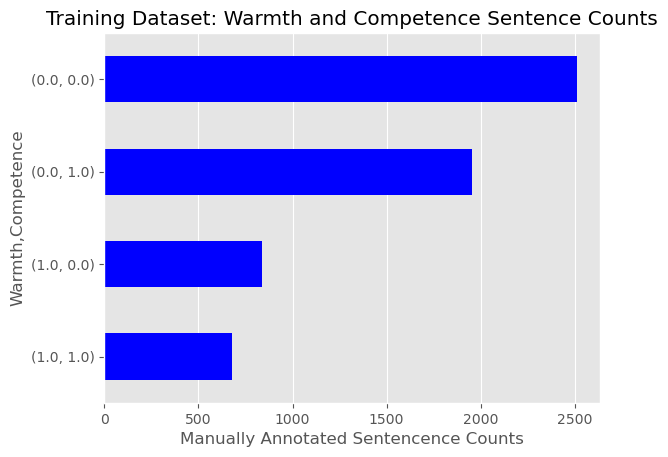

In [73]:
# Visualize data balance
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)

analysis_columns = [
    'Warmth',
    'Competence'
]

df_manual.info()

df_gender_age_info(df_manual, ivs_all = analysis_columns)

warm_comp_count = (
    df_manual[analysis_columns]
    .reset_index()
    .groupby(analysis_columns)
    .count()
    .sort_values(by='index')
)
fig, ax = plt.subplots()
ax.set_title('Training Dataset: Warmth and Competence Sentence Counts')
ax.set_ylabel('Sentences')

warm_comp_count.plot(kind='barh', legend=False, stacked=True, color=['blue'], xlabel='Manually Annotated Sentencence Counts', ax=ax).grid(axis='y')
fig.show()

for save_format in ['eps', 'png']:
    fig.savefig(f'{data_dir}/plots/Manual Warmth and Competence Sentence Counts.{save_format}', format=save_format, dpi=3000, bbox_inches='tight')
